# Decision Analysis - Project 3

## Installs and Imports

In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.1.3
!pip install shap
!pip install captum

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 20.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.2.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random
import os
import warnings
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import PartialDependenceDisplay, partial_dependence, plot_partial_dependence


from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation, GuidedBackprop

In [4]:
def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
set_all_seeds(42)

## Functions, Models and Utilities

### Utils

In [6]:
def plot_columns(df, figsize = (12, 8), color="grey"):
    num_cols = len(df.columns)
    num_rows = (num_cols + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=figsize)
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    for i, column in enumerate(df.columns):
        ax = axes[i // 2, i % 2]
        df[column].plot(kind='hist', ax=ax, title=column, color=color)
        ax.set_title(f"Distribution for {column}")
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    fig.suptitle("Data Distribution Plot")
    plt.tight_layout()
    plt.show()

In [7]:
def plot_stats(accuracy, test_accuracy, f1, f1_test, auc, auc_test):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    color = 'grey'
    axes[0].bar(['Train', 'Test'], [accuracy, test_accuracy], color=color)
    axes[0].axhline(y=0.5, color='red', linestyle='--', label='Random Guess')
    axes[0].set_title('Accuracy')
    axes[0].legend()
    axes[0].set_ylim(0, 1)
    axes[1].bar(['Train', 'Test'], [f1, f1_test], color=color)
    axes[1].set_title('F1 Score')
    axes[1].set_ylim(0, 1)
    axes[2].bar(['Train', 'Test'], [auc, auc_test], color=color)
    axes[2].set_title('AUC')
    axes[2].set_ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [8]:
def use_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_train)
    accuracy = round(accuracy_score(y_train, y_preds), 4)
    f1 = round(f1_score(y_train, y_preds), 4)
    y_preds_positive = model.predict_proba(X_train)[:, 1]
    auc = round(roc_auc_score(y_train, y_preds_positive), 4)

    y_preds = model.predict(X_test)
    accuracy_test = round(accuracy_score(y_test, y_preds), 4)
    f1_test = round(f1_score(y_test, y_preds), 4)
    y_preds_positive = model.predict_proba(X_test)[:, 1]
    auc_test = round(roc_auc_score(y_test, y_preds_positive), 4)
    return model, accuracy, f1, auc, accuracy_test, f1_test, auc_test

In [9]:
def get_logistic_regression_changed_prediction(test_example, columns, coefficients, intercept, classifier):
    sum= 0.0
    epsilon = 1e-3
    example_list = list(test_example)
    zipped_lists = zip(coefficients, example_list, range(len(coefficients)))
    sorted_lists = sorted(zipped_lists, reverse=True)
    sorted_coeffs, example_list, original_order = zip(*sorted_lists)
    example_list = list(example_list)
    original_order = list(original_order)
    sorted_coeffs = list(sorted_coeffs)

    for i in range(len(example_list)):
        sum += example_list[i]*sorted_coeffs[i]
    sum += intercept
    prev_examples = example_list.copy()
    if sum>=0:
        for i in range(len(example_list)):
            val = -1*intercept-epsilon
            for j in range(len(example_list)):
                if i != j:
                    val -= example_list[j]*sorted_coeffs[j]
            example_list[i] = val/sorted_coeffs[i]
            if example_list[i]<0:
                example_list[i] = 0
            elif example_list[i]>1:
                example_list[i] = 1
            else:
                break
    else:
        for i in range(len(example_list)):
            val = -1*intercept+epsilon
            for j in range(len(example_list)):
                if i != j:
                    val -= example_list[j]*sorted_coeffs[j]
            example_list[i] = val/sorted_coeffs[i]
            if example_list[i]<0:
                example_list[i] = 0
            elif example_list[i]>1:
                example_list[i] = 1
            else:
                break

    original_order = [original_order.index(i) for i in range(len(original_order))]
    example_list = [example_list[i] for i in original_order]
    prev_examples = [prev_examples[i] for i in original_order]
    rounded_examples = [round(example, 4) for example in example_list]
    rounded_prevs = [round(example, 4) for example in prev_examples]
    differences = list(np.array(prev_examples) - np.array(example_list))
    differences = [round(diff, 4) for diff in differences]
    print(f"Columns in order: {columns}")
    print(f"Original Example: {rounded_prevs}")
    print(f"New Example Assigned to a different class: {rounded_examples}")
    print(f"Minimal Differences: {differences}")
    print(f"Model's original decision {classifier.predict([prev_examples])}")
    print(f"Model's new decision: {classifier.predict([example_list])}")

In [10]:
def change_class_by_sampling(test_example, columns, coefficients, classifier, epsilon=1e-3):
    example_list = list(test_example)
    prev_examples = example_list.copy()
    original_class = classifier.predict([example_list])[0]
    i=0
    while True:
        zipped_lists = zip(coefficients, example_list, range(len(coefficients)))
        sorted_lists = sorted(zipped_lists, reverse=True)
        sorted_coeffs, example_list, original_order = zip(*sorted_lists)
        example_list = list(example_list)
        original_order = list(original_order)
        sorted_coeffs = list(sorted_coeffs)
        if original_class == 1:
            example_list[i] -= epsilon
        else:
            example_list[i] += epsilon
        if example_list[i]<=0:
            example_list[i] = 0
            i+=1
        elif example_list[i]>=1:
            example_list[i] = 1
            i+=1
        original_order = [original_order.index(i) for i in range(len(original_order))]
        example_list = [example_list[i] for i in original_order]
        new_class = classifier.predict([example_list])[0]
        if new_class != original_class:
            break

    rounded_examples = [round(example, 4) for example in example_list]
    rounded_prevs = [round(example, 4) for example in prev_examples]
    differences = list(np.array(prev_examples) - np.array(example_list))
    differences = [round(diff, 4) for diff in differences]
    print(f"Columns in order: {columns}")
    print(f"Original Example: {rounded_prevs}")
    print(f"New Example Assigned to a different class: {rounded_examples}")
    print(f"Minimal Differences: {differences}")
    print(f"Model's original decision {original_class}")
    print(f"Model's new decision: {new_class}")

def nn_change_class_by_sampling(test_example, columns, classifier, epsilon=1e-3):
    example_list = list(test_example)
    original_class = int(classifier.predict([example_list])[0])

    best_new_example = None
    best_new_class = None
    best_difference = None

    min_change = float('inf')
    for i, criterion in enumerate(columns):
        # print(criterion)
        new_example = example_list.copy()
        new_class = int(classifier.predict([example_list])[0])

        while new_class == original_class and (new_example[i] <= 1 and new_example[i] >= 0):
            new_class = int(classifier.predict([new_example])[0])
            # print(new_example)
            if new_class != original_class:
                difference = np.array(example_list) - np.array(new_example)
                if abs(difference[i]) < min_change:
                    min_change = difference[i]
                    best_difference = difference.copy()
                    best_new_example = new_example.copy()
                    best_new_class = new_class

            if original_class == 1:
                new_example[i] -= epsilon
            else:
                new_example[i] += epsilon

    for i, criterion1 in enumerate(columns):
        for j, criterion2 in enumerate(columns[i+1:], start=i+1):
            # print(f"Combination: {criterion1}, {criterion2}")
            new_example = example_list.copy()
            new_class = int(classifier.predict([new_example])[0])

            while new_class == original_class and (new_example[i] <= 1 and new_example[i] >= 0):
                new_class = int(classifier.predict([new_example])[0])
                # print(new_example)
                if new_class != original_class:
                    difference = np.array(example_list) - np.array(new_example)
                    if abs(difference[i] + difference[j]) < min_change:
                        min_change = difference[i] + difference[j]
                        best_difference = difference.copy()
                        best_new_example = new_example.copy()
                        best_new_class = new_class

                if original_class == 1:
                    new_example[i] -= epsilon
                    new_example[j] -= epsilon
                else:
                    new_example[i] += epsilon
                    new_example[j] -= epsilon

    rounded_prevs = [round(example, 4) for example in example_list]
    rounded_new = [round(example, 4) for example in best_new_example]
    print(f"Columns in order: {columns}")
    print(f"Original Example: {rounded_prevs}")
    print(f"New Example Assigned to a different class: {rounded_new}")
    print(f"Differences: {best_difference}")
    print(f"Model's original decision {original_class}")
    print(f"Model's new decision: {best_new_class}")

In [11]:
def calculate_smallest_change_MCDA(test_example, columns, combined_weights, neural_MCDA_compatible, threshold, most_influential_column = "BI-RADS", skip_cols = []):
    original_class = neural_MCDA_compatible.predict([test_example])[0]
    if original_class == 0:
        epsilon = 1e-3
    else:
        epsilon = -1e-3
    target_weights = [combined_weights[i] for i in range(len(columns)) if (most_influential_column in columns[i] and not any(skip_col in columns[i] for skip_col in skip_cols))]
    test_example_copy = test_example.copy()
    test_example_copy = [0 if (most_influential_column in columns[i] and not any(skip_col in columns[i] for skip_col in skip_cols)) else test_example[i] for i in range(len(columns))]
    value = epsilon
    value += (threshold) - np.sum(np.array(test_example_copy)*np.array(combined_weights))
    value /= sum(target_weights)
    result = test_example.copy()
    for i in range(len(columns)):
        if most_influential_column in columns[i] and not any(skip_col in columns[i] for skip_col in skip_cols):
            result[i] = value

    result = list(result)
    prev_result = list(test_example)
    rounded_result = [round(example, 4) for example in result]
    rounded_prevs = [round(example, 4) for example in prev_result]
    differences = list(np.array(prev_result) - np.array(result))
    differences = [round(diff, 4) for diff in differences]
    print(f"Columns in order: {columns}")
    print(f"Original Example: {rounded_prevs}")
    print(f"New Example Assigned to a different class: {rounded_result}")
    print(f"Minimal Differences: {differences}")
    print(f"Model's original decision {neural_MCDA_compatible.predict([test_example])}")
    print(f"Model's new decision: {neural_MCDA_compatible.predict([result])}")

In [12]:
def get_weights_mcda(model, num_criteria=5):
    weights = model.criteria_layer.weight.detach().numpy()[0]
    interaction_weights = model.interaction_layer.weight.detach().numpy()[0]
    # print(weights, interaction_weights)
    s = weights.sum() + interaction_weights.sum()
    weights = weights/s
    interaction_weights = interaction_weights/s

    interactions = np.zeros((num_criteria, num_criteria))
    weight_id = 0
    for i in range(num_criteria):
        for j in range(i+1,num_criteria):

            interactions[i,j] = interactions[j,i] = interaction_weights[weight_id]
            weight_id+=1

    return weights, interaction_weights, interactions

In [13]:
def explanation_plots_nn(model, X_train, X_test, y_train, y_test, feature_names, model_type="ann"):
    feature_names = X_train.columns

    X_train_torch = torch.tensor(X_train.values).float()
    y_train_torch = torch.tensor(y_train.values).view(-1, 1).float()

    X_test_torch = torch.tensor(X_test.values).float()
    y_test_torch = torch.tensor(y_test.values).view(-1, 1).float()

    ig = IntegratedGradients(model)
    ig_nt = NoiseTunnel(ig)
    dl = DeepLift(model)
    gs = GradientShap(model)
    fa = FeatureAblation(model)
    gbp = GuidedBackprop(model)

    ig_attr_test, delta = ig.attribute(X_test_torch, n_steps=50, return_convergence_delta=True)
    ig_nt_attr_test = ig_nt.attribute(X_test_torch)
    dl_attr_test = dl.attribute(X_test_torch)
    gs_attr_test = gs.attribute(X_test_torch, X_train_torch)
    fa_attr_test = fa.attribute(X_test_torch)
    gbp_attr_test = gbp.attribute(X_test_torch)

    if np.any(np.abs(np.array(delta)) > 0.01):
        print("Warning! High approximation error in IntegratedGradients. Increase n_steps")

    x_axis_data = np.arange(X_test.shape[1])
    x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

    ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

    ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
    ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

    dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
    dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

    gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
    gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

    fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
    fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

    gbp_attr_test_sum = gbp_attr_test.detach().numpy().sum(0)
    gbp_attr_test_norm_sum = gbp_attr_test_sum / np.linalg.norm(gbp_attr_test_sum, ord=1)

    if model_type=="ann":
        lin_weight = model.fc1.weight[0].detach().numpy()
    elif model_type=="mcda":
        weights, interaction_weights, _ = get_weights_mcda(model)
        lin_weight = list(weights) + list(interaction_weights)

    y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

    width = 0.12
    legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Guided Backprop', 'Weights']
    if model_type == "ann":
        legends[-1] = "Weights First Layer"

    plt.figure(figsize=(20, 10))

    ax = plt.subplot()
    ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
    ax.set_ylabel('Attributions')

    FONT_SIZE = 16
    plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
    plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
    plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
    plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

    ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
    ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
    ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
    ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
    ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
    ax.bar(x_axis_data + 5 * width, gbp_attr_test_norm_sum, width, align='center', alpha=1.0, color='#f5bc42')
    ax.bar(x_axis_data + 6 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
    ax.autoscale_view()
    plt.tight_layout()

    ax.set_xticks(x_axis_data + 0.5)
    ax.set_xticklabels(x_axis_data_labels, rotation=30)

    plt.legend(legends, loc=3)
    plt.show()

def explain_examples(model, test_example_list, feature_names, method="integrated_gradients", labels=None):
    test_examples_torch = torch.tensor(test_example_list).float()

    if method == "integrated_gradients":
        method_model = IntegratedGradients(model)
        attr_test, delta = method_model.attribute(test_examples_torch, n_steps=50, return_convergence_delta=True)

        if np.any(np.abs(np.array(delta)) > 0.01):
            print("Warning! High approximation error in IntegratedGradients. Increase n_steps")

    elif method == "guided_backprop":
        method_model = GuidedBackprop(model)
        attr_test = method_model.attribute(test_examples_torch)

    else:
        raise Exception('Please select the method: "integrated_gradients" (default) or "guided_backprop"')

    x_axis_data = np.arange(test_examples_torch.shape[1])
    x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

    width = 0.14
    if labels is None:
        legends = [f"Example {x+1}" for x in range(len(test_example_list))]
    else:
        legends = [f"Example {x+1}. Label: {y}" for x, y in zip(range(len(test_example_list)), labels)]

    plt.figure(figsize=(13, 8))

    ax = plt.subplot()
    text = "Integrated Gradients" if method == "integrated_gradients" else "Guided Backpropagation"
    ax.set_title(f'Comparing input feature importances for selected examples using {text} method')
    ax.set_ylabel('Attributions')

    FONT_SIZE = 16
    plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
    plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
    plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
    plt.rc('legend', fontsize=FONT_SIZE)      # fontsize of the legend

    colors = ['#eb5e7c', '#A90000', '#34b8e0', '#34b8e0']
    for i in range(len(attr_test)):
        ax.bar(x_axis_data + i * width, attr_test[i], width, align='center', alpha=0.8, color=colors[i])

    ax.autoscale_view()
    plt.tight_layout()

    ax.set_xticks(x_axis_data + 0.5)
    ax.set_xticklabels(x_axis_data_labels, rotation=30)

    plt.legend(legends, loc=3)
    plt.show()

### Neural MCDA

In [14]:
def morbius_transform(input_row):
    result = list(input_row)
    for i in range(len(input_row)):
        for j in range(i+1, len(input_row)):
            result.append(min(input_row[i], input_row[j]))

    return np.array(result)

In [15]:
def change_class_by_sampling_MCDA(test_example, columns, coefficients, classifier, most_influencial_column = "BI-RADS", transform = morbius_transform):
    epsilon = 1e-3
    example_list = list(test_example)
    prev_examples = example_list.copy()
    original_class = classifier.predict([example_list])[0]
    while True:
        temp_example_list = example_list[:5]
        if original_class == 1:
            temp_example_list[0] -= epsilon
        else:
            temp_example_list[0] += epsilon
        example_list = transform(temp_example_list)
        new_class = classifier.predict([example_list])[0]
        if new_class != original_class:
            break

    rounded_examples = [round(example, 4) for example in example_list]
    rounded_prevs = [round(example, 4) for example in prev_examples]
    differences = list(np.array(prev_examples) - np.array(example_list))
    differences = [round(diff, 4) for diff in differences]
    print(f"Columns in order: {columns}")
    print(f"Original Example: {rounded_prevs}")
    print(f"New Example Assigned to a different class: {rounded_examples}")
    print(f"Minimal Differences: {differences}")
    print(f"Model's original decision {original_class}")
    print(f"Model's new decision: {new_class}")

In [16]:
class CriteriaLayer(nn.Linear):
    def __init__(self, num_in_features:int, include_bias:bool=False, min_weight:float=1e-8):
        super().__init__(num_in_features, 1, include_bias)
        self.is_bias = include_bias
        self.min_w = min_weight
        if include_bias:
            nn.init.uniform_(self.bias, self.min_w ,1.0)
        else:
            self.bias = None

    def reset_parameters(self):
        nn.init.uniform_(self.weight, 0.1, 1.0)

    def ensure_proper_weights(self):
        with torch.no_grad():
            self.weight.data[self.weight.data<0]=self.min_w
        weights = self.weight
        return weights

    def forward(self, input:torch.Tensor)->torch.Tensor:
        weights = self.ensure_proper_weights()
        return F.linear(input, weights, self.bias)

In [17]:
class InteractionLayer(nn.Linear):
    def __init__(self, num_in_features:int, criterion_layer:CriteriaLayer):
        num_interactions = ((num_in_features-1)*num_in_features)//2
        super().__init__(num_interactions, 1, False)
        self.in_features = num_in_features
        self.criterion_layer = criterion_layer
        self.num_interactions = num_interactions

    def reset_parameters(self):
        nn.init.normal_(self.weight, 0.0, 0.1)

    def ensure_proper_weights(self):
        with torch.no_grad():
            w_i=0
            w = self.criterion_layer.ensure_proper_weights()
            for i in range(self.in_features):
                for j in range(i+1,self.in_features):
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,i])
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,j])
                    w_i+=1
        weights = self.weight
        return weights

    def forward(self, input:torch.Tensor)->torch.Tensor:
        weights = self.ensure_proper_weights()
        return F.linear(input, weights, None)

In [18]:
class ThresholdLayer(nn.Module):
    def __init__(self, threshold: float = None, requires_grad: bool = True):
        super().__init__()
        if threshold is None:
            self.threshold = nn.Parameter(torch.FloatTensor(1).uniform_(0.1, 0.9), requires_grad=requires_grad)
        else:
            self.threshold = nn.Parameter(torch.FloatTensor([threshold]), requires_grad=requires_grad)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return x - self.threshold

In [19]:
class ChoquetIntegralConstrained(nn.Module):
    def __init__(self, num_criteria:int, mobius_transform):
        super().__init__()
        self.num_criteria = num_criteria
        self.criteria_layer = CriteriaLayer(num_criteria)
        self.interaction_layer = InteractionLayer(num_criteria, self.criteria_layer)
        self.threshold_layer = ThresholdLayer()
        self.transform = mobius_transform

    def preprocess(self, input: np.array)->np.array:
        processed = []
        for row in input:
            processed.append(self.transform(row))
        return np.array(processed)

    def forward(self, input:torch.Tensor)->torch.Tensor:
        if len(input.shape)==3:
            input = input[:,0,:]

        x_wi = self.criteria_layer(input[:,:self.num_criteria])
        x_wij = self.interaction_layer(input[:,self.num_criteria:])
        weight_sum = self.criteria_layer.ensure_proper_weights().sum()+self.interaction_layer.ensure_proper_weights().sum()
        score =  (x_wi+x_wij)/(weight_sum)
        output = self.threshold_layer(score)
        return output.squeeze()

In [20]:
def Regret(output: torch.FloatTensor, target: torch.LongTensor) -> torch.FloatTensor:
    return torch.mean(F.relu(-(target >= 1).float() * output) + F.relu((target < 1).float() * output))

### ANN

In [21]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x.squeeze()

class CompatibleTorchModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model, optimizer, criterion, num_epochs, custom_acc_threshold = False):
        super(CompatibleTorchModel, self).__init__()
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.custom_acc_threshold = custom_acc_threshold
        self.classes_ = None
        self.fitted = False

    def fit(self, X_train, y_train):
        print("Fitting Neural Network Model")
        self.classes_ = np.unique(y_train)
        self.model.train()
        train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        history = {'epoch': [], 'accuracy': [], 'loss': []}
        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            correct = 0
            total = 0
            for inputs, targets in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() * inputs.size(0)
                predicted = outputs.detach().numpy()
                if self.custom_acc_threshold:
                    predicted[predicted>=0.0] = 1
                    predicted[predicted<0.0] = 0
                else:
                    predicted[predicted>=0.5] = 1
                    predicted[predicted<0.5] = 0
                total += len(targets)
                expected = targets.numpy()
                correct += np.sum(predicted == expected)
            epoch_loss /= len(train_loader.dataset)
            epoch_accuracy = correct / total
            print(f"Training Results - Epoch: {epoch+1}  Avg accuracy: {round(epoch_accuracy, 4)} Avg loss: {round(epoch_loss, 4)}")
            history['epoch'].append(epoch)
            history['accuracy'].append(epoch_accuracy)
            history['loss'].append(epoch_loss)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['epoch'], history['loss'], label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history['epoch'], history['accuracy'], label='Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()
        self.fitted = True

    def predict(self, X):
        self.model.eval()
        predictions = []
        for temp_X in X:
            X_input = torch.tensor(temp_X).float()
            with torch.no_grad():
                output = self.model(X_input.unsqueeze(0))
            if self.custom_acc_threshold:
                output = 1 if output > 0.0 else 0
            else:
                output = 1 if output > 0.5 else 0
            predictions.append(output)
        return np.array(predictions)

    def predict_proba(self, X):
        self.model.eval()
        predictions = []
        for temp_X in X:
            X_input = torch.tensor(temp_X).float()
            with torch.no_grad():
                output = self.model(X_input.unsqueeze(0))
                output = np.round(output.item(), 4)
                if self.custom_acc_threshold:
                    output += 0.5
                if output>1:
                    output = 1
            predictions.append([1-output, output])
        return np.array(predictions)

    def __sklearn_is_fitted__(self):
        """
        Check fitted status and return a Boolean value.
        Overwritten to save head pain.
        """
        return self.fitted

## Data

https://archive.ics.uci.edu/dataset/161/mammographic+mass

1. BI-RADS assessment: 1 to 5 (ordinal, non-predictive!)  

2. Age: patient's age in years (integer)

3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)

4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)

5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

6. Severity: benign=0 or malignant=1 (binominal, goal field!)

In [22]:
# data = pd.read_csv("/content/mammographic.csv")
data = pd.read_csv("mammographic.csv")
data = (data - data.min()) / (data.max() - data.min())
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data

,BI-RADS,Age,Shape,Margin,Density,Severity
0,0.666667,0.525641,0.000000,0.00,0.666667,0.0
1,0.666667,0.333333,0.333333,0.00,0.666667,0.0
2,0.833333,0.474359,1.000000,1.00,0.666667,0.0
3,0.666667,0.076923,0.333333,0.00,0.666667,0.0
4,0.666667,0.358974,0.000000,0.00,0.666667,0.0
...,...,...,...,...,...,...
825,0.666667,0.615385,0.000000,0.00,0.666667,0.0
826,0.666667,0.038462,0.333333,0.00,0.666667,0.0
827,0.833333,0.833333,1.000000,0.75,0.666667,1.0
828,0.833333,0.628205,1.000000,1.00,0.666667,1.0


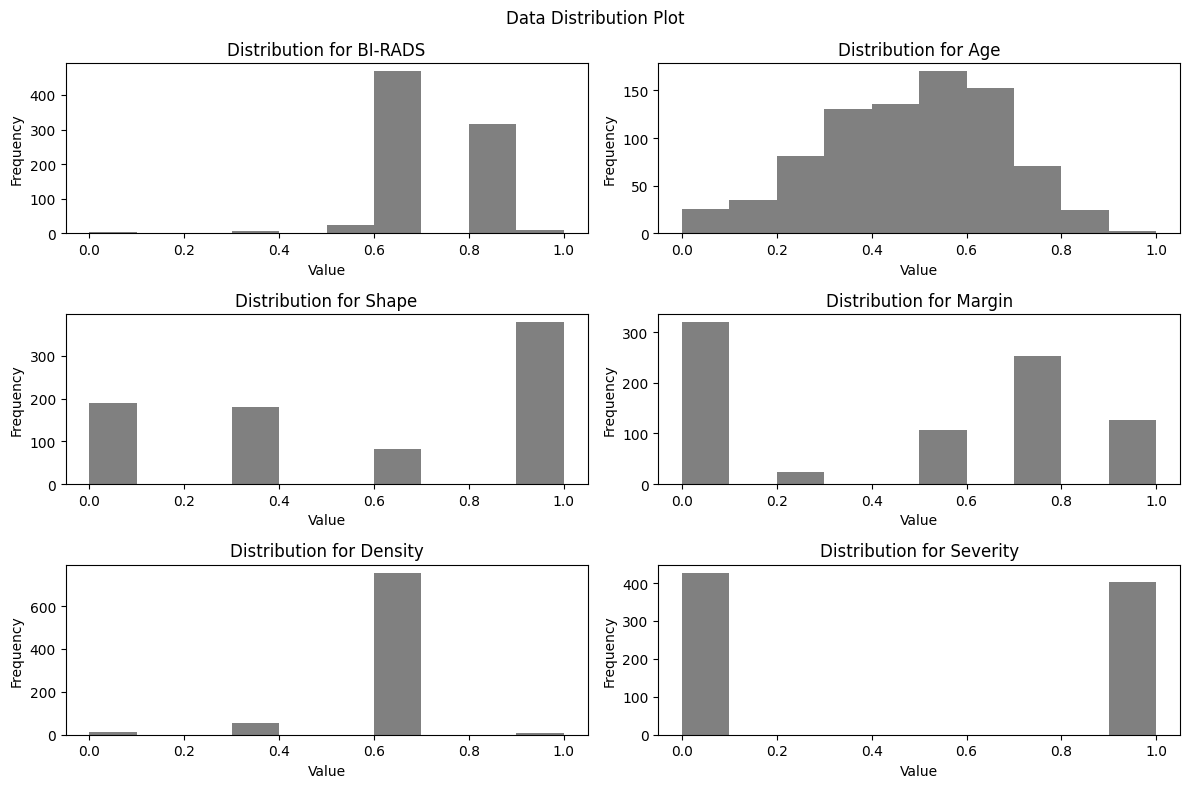

In [23]:
plot_columns(data)

In [24]:
X = data.drop(columns = ["Severity"])
y = data["Severity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
feature_names = X_train.columns

## ANN Model

In [25]:
lr = 1e-3
weight_decay = 1e-4
criterion = nn.BCELoss()
num_epochs = 100

Fitting Neural Network Model
Training Results - Epoch: 1  Avg accuracy: 0.4849 Avg loss: 0.6927
Training Results - Epoch: 2  Avg accuracy: 0.5151 Avg loss: 0.6768
Training Results - Epoch: 3  Avg accuracy: 0.756 Avg loss: 0.6418
Training Results - Epoch: 4  Avg accuracy: 0.7907 Avg loss: 0.5773
Training Results - Epoch: 5  Avg accuracy: 0.7952 Avg loss: 0.5128
Training Results - Epoch: 6  Avg accuracy: 0.7982 Avg loss: 0.4849
Training Results - Epoch: 7  Avg accuracy: 0.7831 Avg loss: 0.4705
Training Results - Epoch: 8  Avg accuracy: 0.8027 Avg loss: 0.4621
Training Results - Epoch: 9  Avg accuracy: 0.8042 Avg loss: 0.4557
Training Results - Epoch: 10  Avg accuracy: 0.7997 Avg loss: 0.451
Training Results - Epoch: 11  Avg accuracy: 0.8087 Avg loss: 0.4518
Training Results - Epoch: 12  Avg accuracy: 0.8087 Avg loss: 0.4387
Training Results - Epoch: 13  Avg accuracy: 0.8193 Avg loss: 0.4367
Training Results - Epoch: 14  Avg accuracy: 0.8072 Avg loss: 0.4364
Training Results - Epoch: 15  

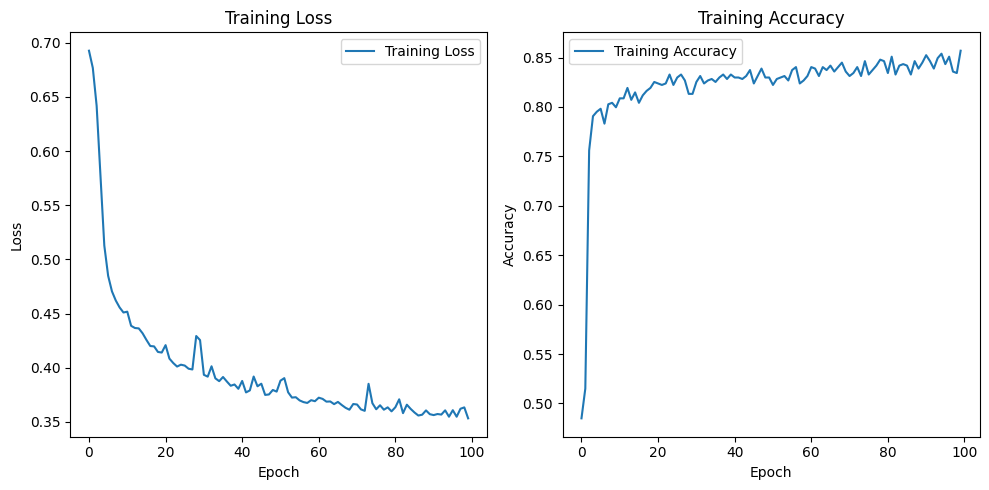

In [26]:
ann_model = ANN(len(X_train.columns), 1)
optimizer = optim.AdamW(ann_model.parameters(), lr=lr, weight_decay=weight_decay)
torch_model = CompatibleTorchModel(ann_model, optimizer, criterion, num_epochs)
torch_model, accuracy, f1, auc, accuracy_test, f1_test, auc_test = use_model(torch_model, X_train.values, y_train.values, X_test.values, y_test.values)
ann_model = torch_model.model

In [27]:
print(f"Train set accuracy: {accuracy}")
print(f"Train set F1: {f1}")
print(f"Train set AUC: {auc}")
print(f"Test set accuracy: {accuracy_test}")
print(f"Test set F1: {f1_test}")
print(f"Test set AUC: {auc_test}")

Train set accuracy: 0.8373
Train set F1: 0.8444
Train set AUC: 0.9201
Test set accuracy: 0.8072
Test set F1: 0.8298
Test set AUC: 0.8907


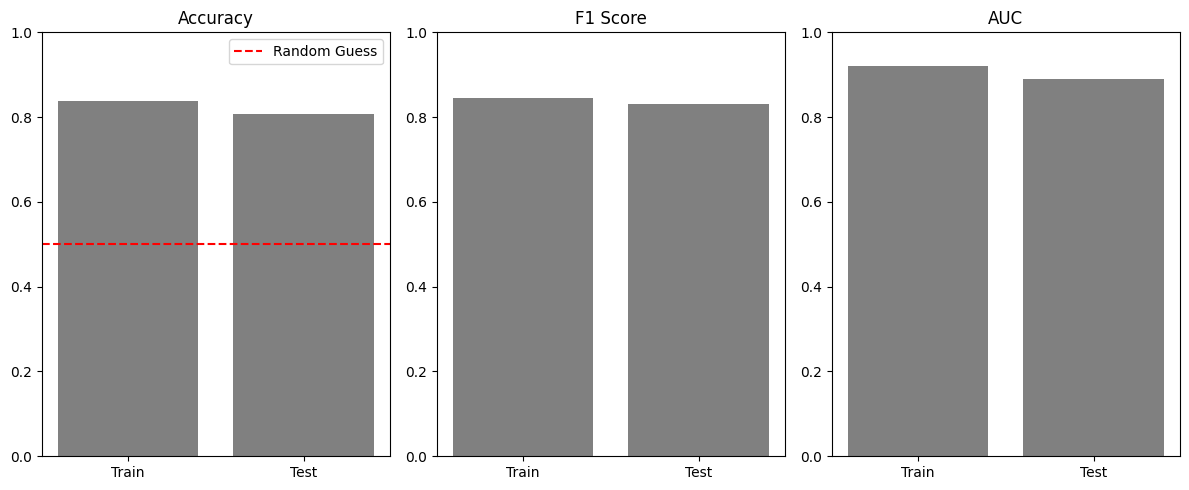

In [28]:
plot_stats(accuracy, accuracy_test, f1, f1_test, auc, auc_test)

### 2.1. Explanation of the decisions

https://captum.ai/tutorials/House_Prices_Regression_Interpret

In [29]:
test_example_1 = X_test.iloc[0]
test_label_1 = torch_model.predict(X_test.iloc[0].values.reshape(1, -1))[0]
true_label_1 = int(y_test.iloc[0])
test_example_2 = X_test.iloc[1]
test_label_2 = torch_model.predict(X_test.iloc[1].values.reshape(1, -1))[0]
true_label_2 = int(y_test.iloc[1])
test_example_3 = X_test.iloc[9]
test_label_3 = torch_model.predict(X_test.iloc[9].values.reshape(1, -1))[0]
true_label_3 = int(y_test.iloc[9])
print(f"Test example:\n{test_example_1}")
print(f"\nAssigned Label: {test_label_1}")
print(f"True Label: {true_label_1}")
print("________________________________")
print(f"Test example:\n{test_example_2}")
print(f"\nAssigned Label: {test_label_2}")
print(f"True Label: {true_label_2}")
print("________________________________")
print(f"Test example:\n{test_example_3}")
print(f"\nAssigned Label: {test_label_3}")
print(f"True Label: {true_label_3}")

Test example:
BI-RADS    0.833333
Age        0.730769
Shape      1.000000
Margin     0.750000
Density    0.666667
Name: 162, dtype: float64

Assigned Label: 1
True Label: 1
________________________________
Test example:
BI-RADS    0.666667
Age        0.666667
Shape      1.000000
Margin     0.250000
Density    0.333333
Name: 305, dtype: float64

Assigned Label: 1
True Label: 1
________________________________
Test example:
BI-RADS    0.666667
Age        0.282051
Shape      0.333333
Margin     0.000000
Density    0.666667
Name: 462, dtype: float64

Assigned Label: 0
True Label: 0


#### Plots for model tests using baseline-based attribution algorithms

Baseline: zero-vector

#### References to used methods:

- Integrated Gradients: https://arxiv.org/pdf/1703.01365.pdf - integrating the interpolation difference between noise and input https://distill.pub/2020/attribution-baselines/

- Noise Tunnel: adds a gaussian noise to each input approximating smoothing attribution method with a Gaussian Kernel. https://arxiv.org/abs/1810.03292, https://arxiv.org/abs/1810.03307, https://arxiv.org/abs/1706.03825, https://arxiv.org/abs/1806.10758

- Deep Lift: https://arxiv.org/abs/1704.02685 - comparing the activation of each neuron to its ‘reference activation’ and assigning contribution scores according to the difference https://edwinwenink.github.io/ai-ethics-tool-landscape/tools/deeplift/

- Gradient SHAP: https://github.com/shap/shap#deep-learning-example-with-gradientexplainer-tensorflowkeraspytorch-models - combines ideas from Integrated Gradients, SHAP, and SmoothGrad into a single expected value equation using the entire dataset as background distribution

- Feature Ablation: replacing each input feature with a given baseline / reference, and computing the difference in output

- Guided Backpropagation: https://arxiv.org/abs/1412.6806 - computes the gradient of the target output with respect to the input, but gradients of ReLU functions are overridden so that only non-negative gradients are backpropagated

Code from: https://captum.ai/tutorials/House_Prices_Regression_Interpret

Warning! High approximation error in IntegratedGradients. Increase n_steps


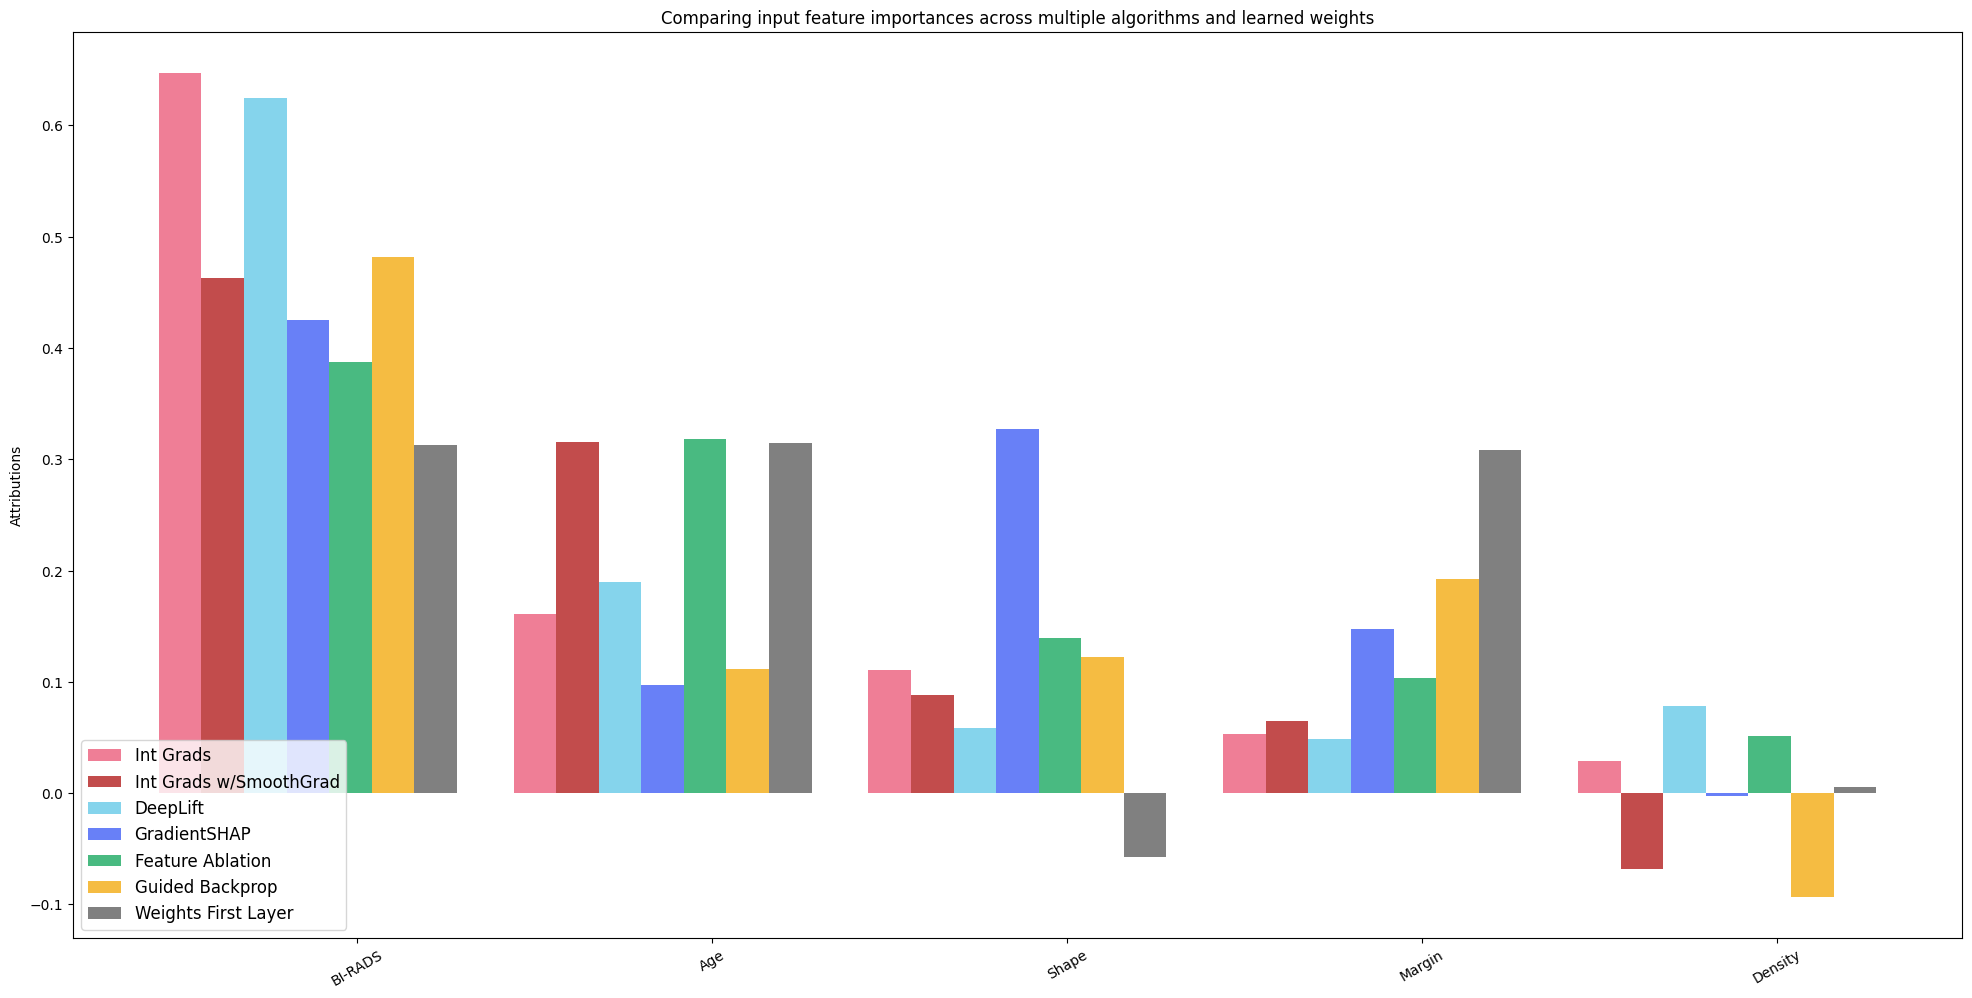

In [30]:
explanation_plots_nn(ann_model, X_train, X_test, y_train, y_test, feature_names)

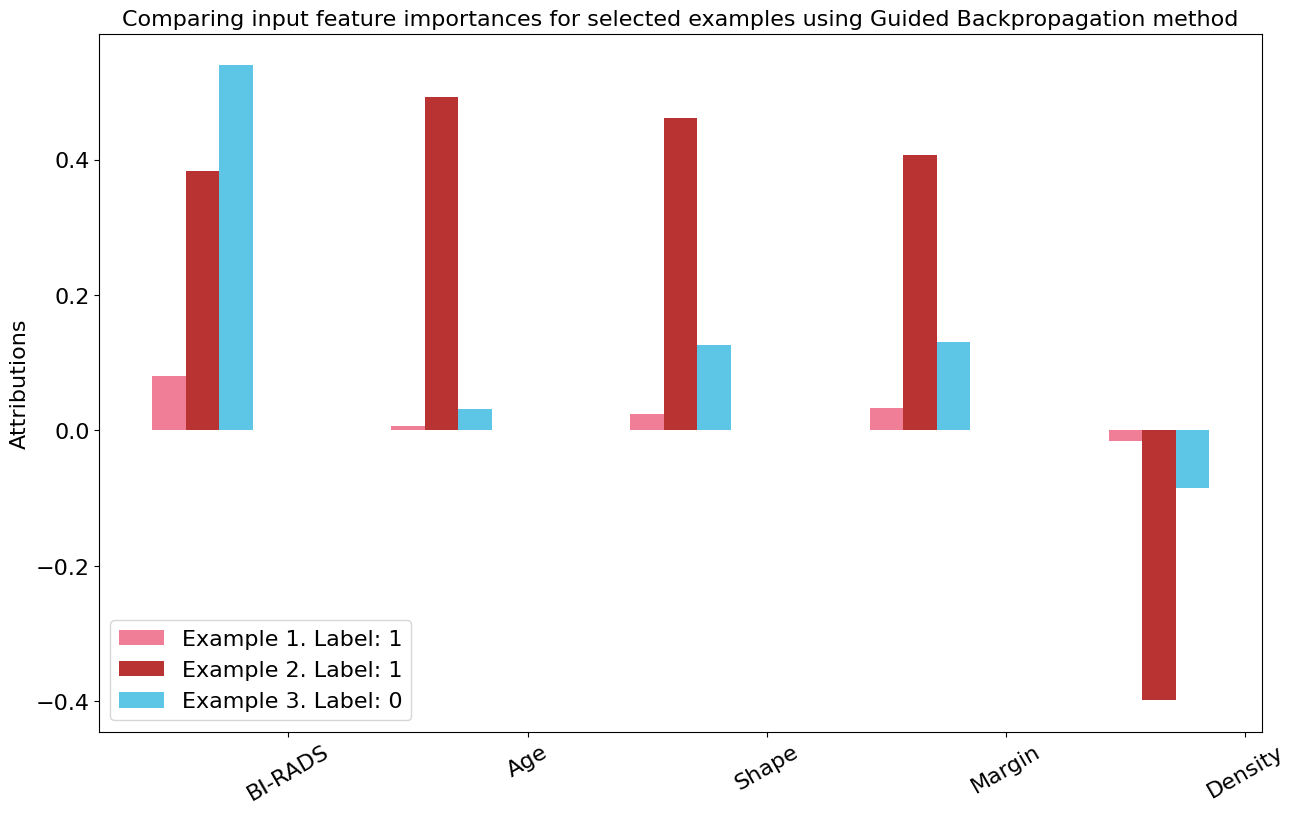

In [31]:
explain_examples(ann_model, [test_example_1.values, test_example_2.values, test_example_3.values], feature_names,
                 method="guided_backprop", labels=[test_label_1, test_label_2, test_label_3])

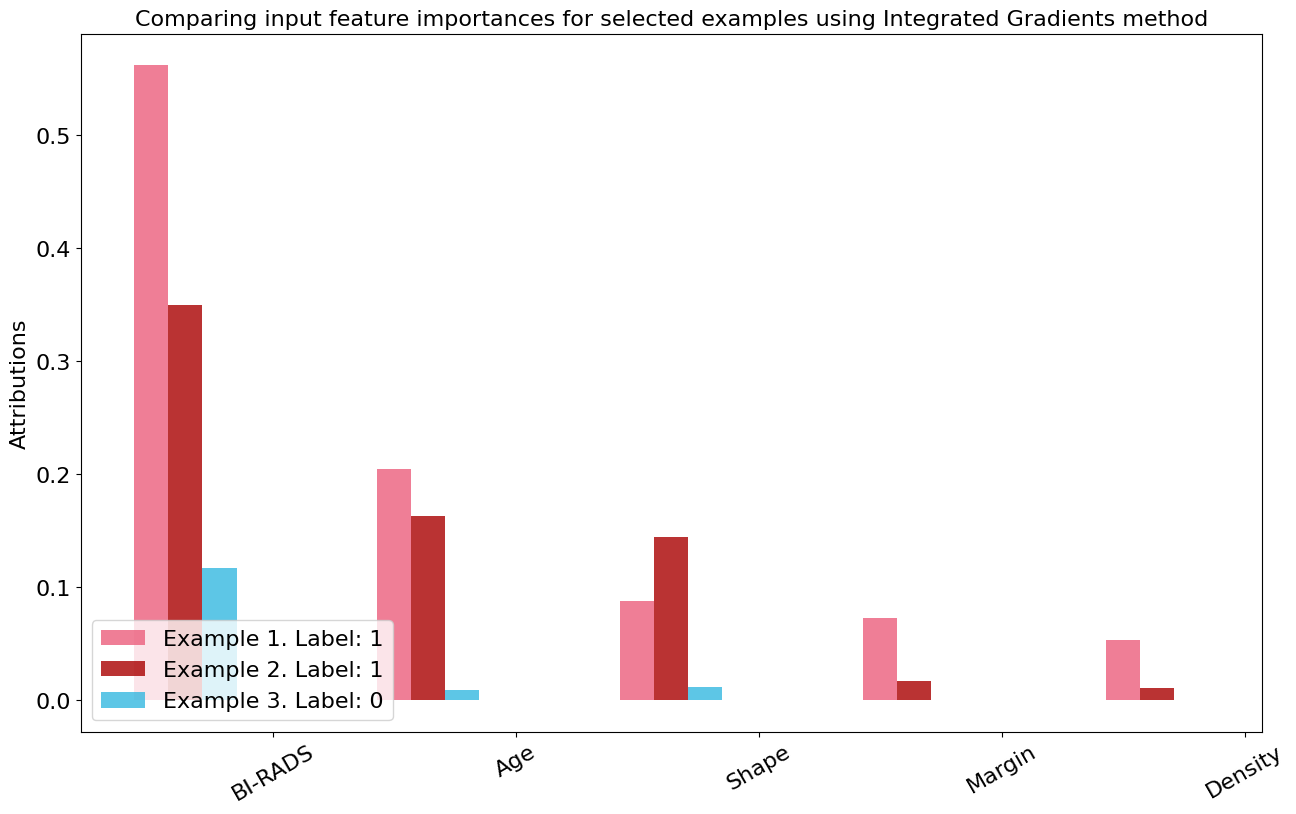

In [32]:
explain_examples(ann_model, [test_example_1.values, test_example_2.values, test_example_3.values], feature_names,
                 method="integrated_gradients", labels=[test_label_1, test_label_2, test_label_3])

#### Explanation of the decision for the selected alternatives:

*Significance of criteria is based on the test-set-aggregated and individual results from feature importance algorithms presented above.*

- test example 1:

High, above average values on every criteria make it a certain member of the positive (severe) class.

- test example 2:

Lower values on less significant features, maximal Shape value which is an influential coefficient and above average Age indicate positive class assignment. This example seems to be very close to being assigned to the opposite class as the most significant feature BI-RADS is not high.

According to the Integrated Gradients test, Margin and Density is not important for the model in context of this example which would make sense considering that low values for these attributes could assign this example to the other, incorrect class.

- test example 3:

Below average BI-RADS value, minimal Margin and low Shape score cause negative (malignant) class assignment, this is shown by the Guided Backpropagation test where Margin has the second most important contributor to the decision.

#### Changes from Theoretical Calculations

In [64]:
columns = X_train.columns

NEW CODE:

In [75]:
## NEW CODE

def change_class_by_guided_gradient(test_example, columns, model):
    model.eval()
    input_data = torch.Tensor(test_example).float()
    input_data = input_data.unsqueeze(0)
    criterion = nn.BCELoss()
    optimizer = optim.SGD([input_data.requires_grad_()], lr=0.01)
    original_output = model(input_data)
    original_class = 1 if original_output.detach().item()>0.5 else 0
    target_class = 1.0 if original_class == 0 else 0.0

    while True:
        output = model(input_data)
        new_class = 1 if output.detach().item()>0.5 else 0
        if new_class == target_class:
            break
        loss = criterion(output.unsqueeze(0), torch.tensor([target_class]))
        optimizer.zero_grad()
        loss.backward()
        input_data.data -= 0.01 * torch.sign(input_data.grad)
        input_data.data = torch.clamp(input_data.data, min=0.0, max=1.0)

    example_list = list(input_data.data.numpy()[0])
    rounded_examples = [round(example, 4) for example in example_list]
    rounded_prevs = [round(example, 4) for example in test_example]
    differences = list(np.array(test_example) - np.array(example_list))
    differences = [round(diff, 4) for diff in differences]
    print(f"Columns in order: {columns}")
    print(f"Original Example: {rounded_prevs}")
    print(f"New Example Assigned to a different class: {rounded_examples}")
    print(f"Minimal Differences: {differences}")
    print(f"Model's original decision {original_class}")
    print(f"Model's new decision: {new_class}")

In [76]:
## NEW CODE

change_class_by_guided_gradient(test_example_1, columns, ann_model)

Columns in order: Index(['BI-RADS', 'Age', 'Shape', 'Margin', 'Density'], dtype='object')
Original Example: [0.8333, 0.7308, 1.0, 0.75, 0.6667]
New Example Assigned to a different class: [0.6333, 0.5308, 0.8, 0.55, 0.5667]
Minimal Differences: [0.2, 0.2, 0.2, 0.2, 0.1]
Model's original decision 1
Model's new decision: 0


In [77]:
## NEW CODE

change_class_by_guided_gradient(test_example_2, columns, ann_model)

Columns in order: Index(['BI-RADS', 'Age', 'Shape', 'Margin', 'Density'], dtype='object')
Original Example: [0.6667, 0.6667, 1.0, 0.25, 0.3333]
New Example Assigned to a different class: [0.6267, 0.6267, 0.96, 0.21, 0.3133]
Minimal Differences: [0.04, 0.04, 0.04, 0.04, 0.02]
Model's original decision 1
Model's new decision: 0


In [78]:
## NEW CODE

change_class_by_guided_gradient(test_example_3, columns, ann_model)

Columns in order: Index(['BI-RADS', 'Age', 'Shape', 'Margin', 'Density'], dtype='object')
Original Example: [0.6667, 0.2821, 0.3333, 0.0, 0.6667]
New Example Assigned to a different class: [0.7467, 0.3621, 0.4133, 0.08, 0.6067]
Minimal Differences: [-0.08, -0.08, -0.08, -0.08, 0.06]
Model's original decision 0
Model's new decision: 1


#### Changes from Sampling


In [79]:
nn_change_class_by_sampling(test_example_1, list(X_train.columns), torch_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.8333, 0.7308, 1.0, 0.75, 0.6667]
New Example Assigned to a different class: [0.5993, 0.4968, 1.0, 0.75, 0.6667]
Differences: [0.234 0.234 0.    0.    0.   ]
Model's original decision 1
Model's new decision: 0


In [80]:
nn_change_class_by_sampling(test_example_2, list(X_train.columns), torch_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.6667, 0.6667, 1.0, 0.25, 0.3333]
New Example Assigned to a different class: [0.6097, 0.6097, 1.0, 0.25, 0.3333]
Differences: [0.057 0.057 0.    0.    0.   ]
Model's original decision 1
Model's new decision: 0


In [81]:
nn_change_class_by_sampling(test_example_3, list(X_train.columns), torch_model)

Columns in order: ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
Original Example: [0.6667, 0.2821, 0.3333, 0.0, 0.6667]
New Example Assigned to a different class: [0.7867, 0.2821, 0.3333, 0.0, 0.6667]
Differences: [-0.12  0.    0.    0.    0.  ]
Model's original decision 0
Model's new decision: 1


### SHAP explanation

In [ ]:
explainer = shap.Explainer(torch_model.predict, X_train.values, feature_names=X_train.columns)

shap_values = explainer(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns)

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.waterfall(shap_values[1])

In [ ]:
shap.plots.waterfall(shap_values[9])

In [ ]:
shap.plots.scatter(shap_values[:, "BI-RADS"], color=shap_values)

#### Explanation of the decision for the selected alternatives based on SHAP technique:

- test example 1:

SHAP analysis confirms that above average scores in each feature positively contribute to the decision with the Age and BI-RADS having the highest influence. This makes sense as Age is the second most important coefficient of the model and the value for this example is high. Third in influence is Shape which is also understandable as this example achieves the highest possible Shape value.

- test example 2:

In this example, low values of low significance features and below average BI-RADS score are offset by maximal Shape value and high Age value. Low influence of Margin and Density attributes align with the Integrated Gradients test result.

- test example 3:

The below average BI-RADS value has the highest influence on the decision with the remaining attributes also supporting the negative decision. Influence of higher values of Density is seemingly turned off for this example. This situation aligns with the Integrated Gradients test results although the influence of Margin feature does not.

### Partial Dependence Plot

TODO: verify - why squiggly? not squiggly earlier? hmmmm....

In [ ]:
fig, ax = plt.subplots(figsize=(14, 20))
PartialDependenceDisplay.from_estimator(torch_model, X_test.values, features = [0, 1, 2, 3, 4] + [(a,b) for a in range(5) for b in range(a+1, 5)],
                                         ax=ax, response_method="predict_proba", feature_names=X_train.columns)

#### Conclusions

Based on the performed analysis, we can say that the BI-RADS score is the most influential feature in the model's decision making. Age and Shape attributes seem to also have a significant influence with Age being more important according to the Partial Dependence Plot. Shape and Margin attributes seem to be the least significant in the presented measures. All features have a positive impact on the classification - the increase of value increase the probability of assignment to the positive (severe) class. The least significant attribute is Density which is reflected both by the feature importance methods and the Partial Dependency Plot. Performance of the model is slightly better than that of Logistic Regression model on all shown metrics.

### 2.2. Interpretation of the model

• Based on the parameters obtained, can we say something about the user’s preferences? <br>

Based on the feature importance methods we can say that the BI-RADS is the most important criteria in the decision making process followed by Age, Shape and Margin with similar importances. The Density attribute seems to be not influential in the process.

• What was the influence of the criteria? Are there any criteria that have no effect, or have a decisive influence? <br>

All criteria have a positive influence on the decision - higher values increase probablility of assgnment to the positive (severe) class. BI-RADS seems to be the most decisive criteria although Age is also an important attribute. On the other hand, Density seems to have close to no effect - a fact which is reflected by all tests to some extent.

• Are there any dependencies between the criteria? <br>

TODO: idk

• What is the nature of the criterion, gain, cost, non-monotonic? <br>

The criteria are of gain type, they have a positive influence on the decision higher values increase probablility of assgnment to the positive (severe) class.

Density could possibly be a non monotonic criterion as shown on the Partial Dependence Plot although the influence of this change is minimal.

• Whether there are any preference thresholds? Are there any evaluations on criteria that are indifferent in terms of preferences? <br>

TODO: idk

• Interpret the model by at least one (Global Surrogate, Partial Dependence Plot, Permutation Feature Importance ...) <br>

According to the Partial Dependence Plot, the most influential is the BI-RADS attribute followed by the Age feature. Both Shape and Margin seem to have a similar influence on the decision. The Density attribute seems to have very little effect on the classification, the plot slightly decreases above 0.6 values which is not expected however might be negligible in the process.